# Description

* Time to make a simple SIP data simulation with the [dataset](./1_dataset.ipynb) that you alreadly created

# Setting variables

* "workDir" is the path to the working directory for this analysis (where the files will be download to)
  * **NOTE:** MAKE SURE to modify this path to the directory where YOU want to run the example.
* "nprocs" is the number of processors to use (3 by default, since only 3 genomes). Change this if needed.

In [84]:
workDir = '/home/nick/t/SIPSim_wSeq/'
nprocs = 3

# Init

In [85]:
import os
import glob

In [86]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [87]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)

In [88]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir    

genomeDir = os.path.join(workDir, 'genomes_rn')

/home/nick/t/SIPSim_wSeq


# Experimental design

* How many gradients?
* Which are labeled treatments & which are controls?
* For this tutorial, we'll keep things simple and just simulate one control & one treatment
  * For the labeled treatment, 34% of the taxa (1 of 3) will incorporate 50% isotope

The script below ("`SIPSim incorpConfigExample`") is helpful for making simple experimental designs

In [89]:
%%bash
source activate py27

# creating example config
SIPSim incorp_config_example \
  --percTaxa 34 \
  --percIncorpUnif 50 \
  --n_reps 1 \
  > incorp.config

In [90]:
!cat incorp.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
        
        [[[end]]]
            
            [[[[interPopDist 1]]]]
                distribution = uniform
                start = 0
                end = 0
[2]
    # 'treatment' community: possible incorporation
    treatment = labeled
    max_perc_taxa_incorp = 34
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            [[[[interPopDist 1]]]]
                start = 50
                distribution = uniform
                end = 50
        
        [[[end]]]
            [[[[interPopDist 1]]]]
                start = 50
                distribution = uniform
                end = 50
    


## Pre-fractionation communities

* What is the relative abundance of taxa in the pre-fractionation samples?

In [91]:
%%bash
source activate py27

SIPSim communities \
    --config incorp.config \
    ./genomes_rn/genome_index.txt \
    > comm.txt  

In [92]:
!cat comm.txt

library	taxon_name	rel_abund_perc	rank
1	Clostridium_ljungdahlii_DSM_13528	50.800380062	1
1	Streptomyces_pratensis_ATCC_33331	46.262806759	2
1	Escherichia_coli_1303	2.936813179	3
2	Clostridium_ljungdahlii_DSM_13528	58.573608475	1
2	Streptomyces_pratensis_ATCC_33331	37.205285797	2
2	Escherichia_coli_1303	4.221105728	3


**Note:** "library" = gradient

## Simulating gradient fractions

* BD size ranges for each fraction (& start/end of the total BD range)

In [93]:
%%bash 
source activate py27

SIPSim gradient_fractions \
    --BD_min 1.67323 \
    --BD_max 1.7744 \
    comm.txt \
    > fracs.txt    

In [94]:
!head -n 6 fracs.txt

library	fraction	BD_min	BD_max	fraction_size
1	1	1.673	1.674	0.001
1	2	1.674	1.678	0.004
1	3	1.678	1.681	0.003
1	4	1.681	1.684	0.003
1	5	1.684	1.688	0.004


# Simulating fragments

* Simulating shotgun-fragments
* Fragment length distribution: skewed-normal

### Primer sequences

* If you were to simulate amplicons, instead of shotgun fragments, you can use something like the following

In [95]:
# primers = """>515F
# GTGCCAGCMGCCGCGGTAA
# >806R
# GGACTACHVGGGTWTCTAAT
# """

# F = os.path.join(workDir, '515F-806R.fna')
# with open(F, 'wb') as oFH:
#     oFH.write(primers)
    
# print 'File written: {}'.format(F)

### Simulation

In [96]:
%%bash -s $genomeDir
source activate py27 

# skewed-normal
SIPSim fragments \
    $1/genome_index.txt \
    --fp $1 \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 1000 \
    --debug \
    --tbl \
    > shotFrags.txt       

Processing: "Clostridium_ljungdahlii_DSM_13528"
  Genome name: Clostridium_ljungdahlii_DSM_13528
  Genome length (bp): 4630065
  Number of amplicons: None
  Number of fragments simulated: 1000
Processing: "Escherichia_coli_1303"
  Genome name: Escherichia_coli_1303
  Genome length (bp): 4948797
  Number of amplicons: None
  Number of fragments simulated: 1000
Processing: "Streptomyces_pratensis_ATCC_33331"
  Genome name: Streptomyces_pratensis_ATCC_33331
  Genome length (bp): 7337497
  Number of amplicons: None
  Number of fragments simulated: 1000


In [97]:
!head -n 5 shotFrags.txt
!tail -n 5 shotFrags.txt

taxon_name	scaffoldID	fragStart	fragLength	fragGC
Clostridium_ljungdahlii_DSM_13528	NC_014328_1_Clostridium_ljungdahlii_DSM_13528	2155647	7507	29.7056080991
Clostridium_ljungdahlii_DSM_13528	NC_014328_1_Clostridium_ljungdahlii_DSM_13528	2717579	9035	28.43386829
Clostridium_ljungdahlii_DSM_13528	NC_014328_1_Clostridium_ljungdahlii_DSM_13528	4462489	7510	33.1424766977
Clostridium_ljungdahlii_DSM_13528	NC_014328_1_Clostridium_ljungdahlii_DSM_13528	3115878	6481	31.5229131307
Streptomyces_pratensis_ATCC_33331	NC_016114_1_Streptomyces_pratensis_ATCC_33331	7011878	5852	69.6855775803
Streptomyces_pratensis_ATCC_33331	NC_016114_1_Streptomyces_pratensis_ATCC_33331	1132328	8404	76.0352213232
Streptomyces_pratensis_ATCC_33331	NC_016114_1_Streptomyces_pratensis_ATCC_33331	2762390	9433	71.7163150641
Streptomyces_pratensis_ATCC_33331	NC_016114_1_Streptomyces_pratensis_ATCC_33331	3936713	7896	67.8064842958
Streptomyces_pratensis_ATCC_33331	NC_016114_1_Streptomyces_pratensis_ATCC_33331	3085501	6888	68.

### Plotting fragments

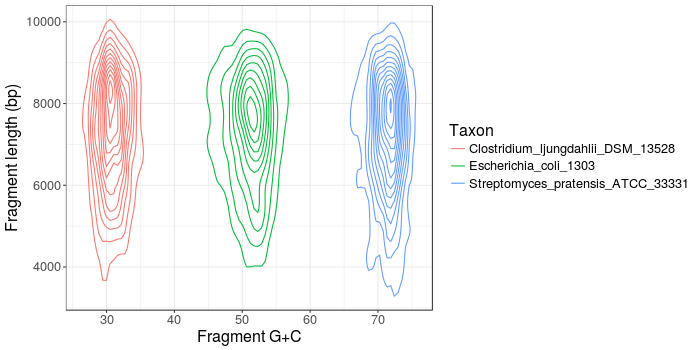

In [98]:
%%R -w 700 -h 350

df = read.delim('shotFrags.txt')

p = ggplot(df, aes(fragGC, fragLength, color=taxon_name)) +
    geom_density2d() +
    scale_color_discrete('Taxon') +
    labs(x='Fragment G+C', y='Fragment length (bp)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
plot(p)

**Note:** for information on what's going on in this config file, use the command: `SIPSim isotope_incorp -h`

## Converting fragments to a 2d-KDE

* Estimating the joint-probabilty for fragment G+C & length

In [99]:
%%bash 
source activate py27

SIPSim fragment_KDE \
    shotFrags.txt \
    > shotFrags_kde.pkl

In [100]:
!ls -thlc shotFrags_kde.pkl

-rw-rw-r-- 1 nick nick 49K Jul  9 14:05 shotFrags_kde.pkl


* **Note:** The generated list of KDEs (1 per taxon per gradient) are in a binary file format
  * To get a table of length/G+C values, use the command: `SIPSim KDE_sample`

## Adding diffusion 

* Simulating the BD distribution of fragments as Gaussian distributions. 
  * One Gaussian distribution per homogeneous set of DNA molecules (same G+C and length)

In [101]:
%%bash 
source activate py27

SIPSim diffusion \
    shotFrags_kde.pkl \
    --np 3 \
    > shotFrags_kde_dif.pkl        

Index size: 90508
Processing: Escherichia_coli_1303
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Clostridium_ljungdahlii_DSM_13528


In [102]:
!ls -thlc shotFrags_kde_dif.pkl 

-rw-rw-r-- 1 nick nick 12M Jul  9 14:05 shotFrags_kde_dif.pkl


# Plotting fragment distribution w/ and w/out diffusion

## Making a table of fragment values from KDEs

In [103]:
n = 100000

In [104]:
%%bash -s $n
source activate py27

SIPSim KDE_sample -n $1 shotFrags_kde.pkl > shotFrags_kde.txt
SIPSim KDE_sample -n $1 shotFrags_kde_dif.pkl > shotFrags_kde_dif.txt

ls -thlc shotFrags_kde*.txt

-rw-rw-r-- 1 nick nick 4.2M Jul  9 14:05 shotFrags_kde_dif.txt
-rw-rw-r-- 1 nick nick 4.2M Jul  9 14:05 shotFrags_kde.txt


## Plotting

In [105]:
%%R
df1 = read.delim('shotFrags_kde.txt', sep='\t')
df2 = read.delim('shotFrags_kde_dif.txt', sep='\t')

df1$data = 'no diffusion'
df2$data = 'diffusion'
df = rbind(df1, df2) %>%
    gather(Taxon, BD, Clostridium_ljungdahlii_DSM_13528, 
           Escherichia_coli_1303, Streptomyces_pratensis_ATCC_33331) %>%
    mutate(Taxon = gsub('_(ATCC|DSM)', '\n\\1', Taxon))

df %>% head(n=3)

  libID         data                              Taxon       BD
1     1 no diffusion Clostridium_ljungdahlii\nDSM_13528 1.690149
2     1 no diffusion Clostridium_ljungdahlii\nDSM_13528 1.690362
3     1 no diffusion Clostridium_ljungdahlii\nDSM_13528 1.687843


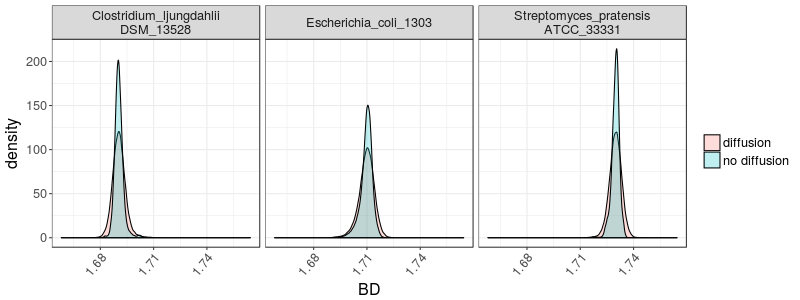

In [106]:
%%R -w 800 -h 300

p = ggplot(df, aes(BD, fill=data)) +
    geom_density(alpha=0.25) +
    facet_wrap( ~ Taxon) +    
    scale_fill_discrete('') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=50, hjust=1)
        )

plot(p)

# Adding diffusive boundary layer (DBL) effects

In [109]:
%%bash 
source activate py27

SIPSim DBL \
    shotFrags_kde_dif.pkl \
    --np 3 \
    > shotFrags_kde_dif_DBL.pkl

DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303


In [110]:
# viewing DBL logs
!ls -thlc *pkl

-rw-rw-r-- 1 nick nick 12M Jul  9 14:06 shotFrags_kde_dif_DBL.pkl
-rw-rw-r-- 1 nick nick 12M Jul  9 14:05 shotFrags_kde_dif.pkl
-rw-rw-r-- 1 nick nick 49K Jul  9 14:05 shotFrags_kde.pkl


# Adding isotope incorporation

* Using the config file produced in the Experimental Design section

In [111]:
%%bash
source activate py27

SIPSim isotope_incorp \
    --comm comm.txt \
    --np 3 \
    shotFrags_kde_dif_DBL.pkl \
    incorp.config \
    > shotFrags_KDE_dif_DBL_inc.pkl

Loading KDE object...
Processing library: 1
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Escherichia_coli_1303
Processing: Streptomyces_pratensis_ATCC_33331
Processing library: 2
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Escherichia_coli_1303
Processing: Streptomyces_pratensis_ATCC_33331
File written: BD-shift_stats.txt


In [112]:
!ls -thlc *.pkl

-rw-rw-r-- 1 nick nick 23M Jul  9 14:07 shotFrags_KDE_dif_DBL_inc.pkl
-rw-rw-r-- 1 nick nick 12M Jul  9 14:06 shotFrags_kde_dif_DBL.pkl
-rw-rw-r-- 1 nick nick 12M Jul  9 14:05 shotFrags_kde_dif.pkl
-rw-rw-r-- 1 nick nick 49K Jul  9 14:05 shotFrags_kde.pkl


**Note:** statistics on how much isotope was incorporated by each taxon are listed in "BD-shift_stats.txt"

In [113]:
%%R
df = read.delim('BD-shift_stats.txt', sep='\t')
df 

  library                             taxon          min          q25
1       1 Clostridium_ljungdahlii_DSM_13528 9.992007e-15 1.554312e-14
2       1             Escherichia_coli_1303 1.909584e-14 2.131628e-14
3       1 Streptomyces_pratensis_ATCC_33331 2.953193e-14 3.108624e-14
4       2 Clostridium_ljungdahlii_DSM_13528 0.000000e+00 0.000000e+00
5       2             Escherichia_coli_1303 1.800000e-02 1.800000e-02
6       2 Streptomyces_pratensis_ATCC_33331 0.000000e+00 0.000000e+00
          mean       median          q75          max
1 2.128831e-14 2.131628e-14 2.686740e-14 3.264056e-14
2 2.359371e-14 2.353673e-14 2.575717e-14 2.797762e-14
3 3.264068e-14 3.264056e-14 3.419487e-14 3.574918e-14
4 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5 1.800000e-02 1.800000e-02 1.800000e-02 1.800000e-02
6 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00


# Making an OTU table

* Number of amplicon-fragment in each fraction in each gradient
* Assuming a total pre-fractionation community size of 1e7

In [114]:
%%bash
source activate py27

SIPSim OTU_table \
    --abs 1e7 \
    --np 3 \
    shotFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    > OTU.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Clostridium_ljungdahlii_DSM_13528"
   taxon abs-abundance:  5080038
  Processing taxon: "Streptomyces_pratensis_ATCC_33331"
   taxon abs-abundance:  4626281
  Processing taxon: "Escherichia_coli_1303"
   taxon abs-abundance:  293681
Processing library: "2"
  Processing taxon: "Clostridium_ljungdahlii_DSM_13528"
   taxon abs-abundance:  5857361
  Processing taxon: "Streptomyces_pratensis_ATCC_33331"
   taxon abs-abundance:  3720529
  Processing taxon: "Escherichia_coli_1303"
   taxon abs-abundance:  422111


In [115]:
!head -n 7 OTU.txt

library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Clostridium_ljungdahlii_DSM_13528	-inf-1.673	-inf	1.672	1.672	2183	0.832253145254
1	Clostridium_ljungdahlii_DSM_13528	1.673-1.674	1.673	1.673	1.674	268	0.943661971831
1	Clostridium_ljungdahlii_DSM_13528	1.674-1.678	1.674	1.676	1.678	3454	0.96832071769
1	Clostridium_ljungdahlii_DSM_13528	1.678-1.681	1.678	1.679	1.681	20758	0.99258834218
1	Clostridium_ljungdahlii_DSM_13528	1.681-1.684	1.681	1.683	1.684	133251	0.99932503881
1	Clostridium_ljungdahlii_DSM_13528	1.684-1.688	1.684	1.686	1.688	1054980	0.999822776868


### Plotting fragment count distributions

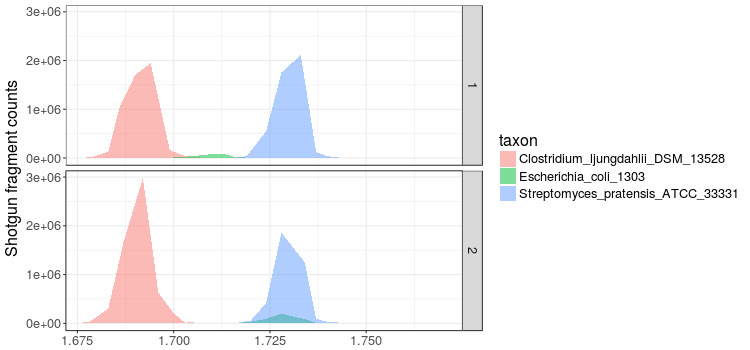

In [116]:
%%R -h 350 -w 750

df = read.delim('OTU.txt', sep='\t')

p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    scale_x_continuous(expand=c(0,0)) +
    labs(x='Buoyant density') +
    labs(y='Shotgun fragment counts') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
    )
plot(p)

**Notes:** 

* This plot represents the theoretical number of amplicon-fragments at each BD across each gradient. 
  * Derived from subsampling the fragment BD proability distributions generated in earlier steps.
* The fragment BD distribution of one of the 3 taxa should have shifted in Gradient 2 (the treatment gradient).
* The fragment BD distributions of the other 2 taxa should be approx. the same between the two gradients.

### Viewing fragment counts as relative quantities 

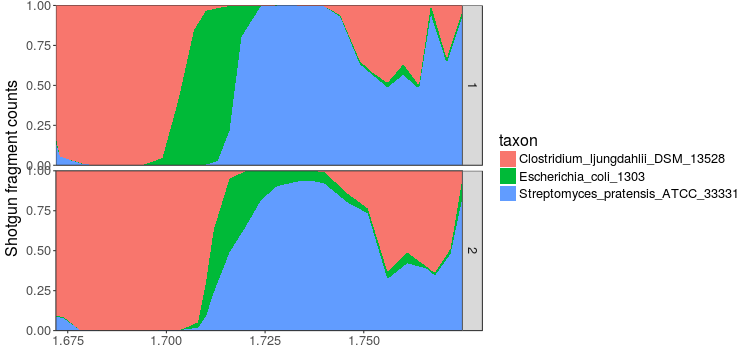

In [117]:
%%R -h 350 -w 750

p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_area(stat='identity', position='fill') +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    labs(x='Buoyant density') +
    labs(y='Shotgun fragment counts') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
    )
plot(p)

# Adding effects of PCR

* This will alter the fragment counts based on the PCR kinetic model of:
>Suzuki MT, Giovannoni SJ. (1996). Bias caused by template annealing in the
  amplification of mixtures of 16S rRNA genes by PCR. Appl Environ Microbiol
  62:625-630.

In [118]:
%%bash
source activate py27

SIPSim OTU_PCR OTU.txt > OTU_PCR.txt    

In [119]:
!head -n 5 OTU_PCR.txt
!tail -n 5 OTU_PCR.txt

library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Clostridium_ljungdahlii_DSM_13528	-inf-1.673	-inf	1.672	1.672	9676914	0.483845684798
1	Clostridium_ljungdahlii_DSM_13528	1.673-1.674	1.673	1.673	1.674	13026686	0.651334263393
1	Clostridium_ljungdahlii_DSM_13528	1.674-1.678	1.674	1.676	1.678	11957464	0.597873188777
1	Clostridium_ljungdahlii_DSM_13528	1.678-1.681	1.678	1.679	1.681	14304771	0.715238538468
2	Streptomyces_pratensis_ATCC_33331	1.758-1.765	1.758	1.761	1.765	7457624	0.372881205372
2	Streptomyces_pratensis_ATCC_33331	1.765-1.767	1.765	1.766	1.767	7981631	0.39908154703
2	Streptomyces_pratensis_ATCC_33331	1.767-1.769	1.767	1.768	1.769	7610264	0.380513183931
2	Streptomyces_pratensis_ATCC_33331	1.769-1.774	1.769	1.772	1.774	7990077	0.39950381567
2	Streptomyces_pratensis_ATCC_33331	1.774-inf	1.775	1.775	inf	9523320	0.476166000541


**Notes**

* The table is in the same format as with the original OTU table, but the counts and relative abundances should be altered.

# Simulating sequencing

* Sampling from the OTU table

In [120]:
%%bash
source activate py27

SIPSim OTU_subsample OTU_PCR.txt > OTU_PCR_sub.txt

In [121]:
!head -n 5 OTU_PCR_sub.txt

library	fraction	taxon	BD_min	BD_mid	BD_max	count	rel_abund
1	-inf-1.673	Clostridium_ljungdahlii_DSM_13528	-inf	1.672	1.672	9781	0.481135323921
1	1.673-1.674	Clostridium_ljungdahlii_DSM_13528	1.673	1.673	1.674	12535	0.647435566345
1	1.674-1.678	Clostridium_ljungdahlii_DSM_13528	1.674	1.676	1.678	10638	0.598750492486
1	1.678-1.681	Clostridium_ljungdahlii_DSM_13528	1.678	1.679	1.681	10253	0.718601065321


**Notes**

* The table is in the same format as with the original OTU table, but the counts and relative abundances should be altered.

### Plotting

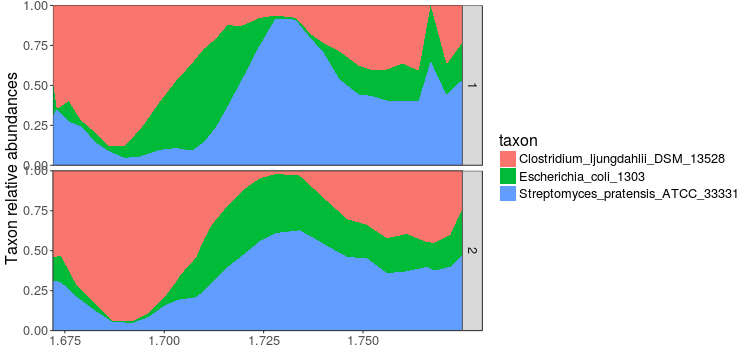

In [122]:
%%R -h 350 -w 750

df = read.delim('OTU_PCR_sub.txt', sep='\t')


p = ggplot(df, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_area(stat='identity', position='fill') +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    labs(x='Buoyant density') +
    labs(y='Taxon relative abundances') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
    )
plot(p)

**Notes**

* The BD shift of 1 taxon in the treatment gradient is harder to see after simulating PCR & sequencing versus just looking at all fragments in the gradient (the original OTU table of fragment counts)

# Misc

### A 'wide' OTU table

* If you want to reformat the OTU table to a more standard 'wide' format (as used in Mothur or QIIME):

In [123]:
%%bash
source activate py27

SIPSim OTU_wide_long -w \
    OTU_PCR_sub.txt \
    > OTU_PCR_sub_wide.txt

In [124]:
!head -n 4 OTU_PCR_sub_wide.txt

taxon	1__-inf-1.673	1__1.673-1.674	1__1.674-1.678	1__1.678-1.681	1__1.681-1.684	1__1.684-1.688	1__1.688-1.691	1__1.691-1.697	1__1.697-1.701	1__1.701-1.705	1__1.705-1.708	1__1.708-1.711	1__1.711-1.715	1__1.715-1.717	1__1.717-1.721	1__1.721-1.726	1__1.726-1.730	1__1.730-1.736	1__1.736-1.738	1__1.738-1.742	1__1.742-1.747	1__1.747-1.751	1__1.751-1.754	1__1.754-1.758	1__1.758-1.761	1__1.761-1.766	1__1.766-1.768	1__1.768-1.774	1__1.774-inf	2__-inf-1.673	2__1.673-1.675	2__1.675-1.681	2__1.681-1.685	2__1.685-1.689	2__1.689-1.694	2__1.694-1.697	2__1.697-1.702	2__1.702-1.703	2__1.703-1.706	2__1.706-1.709	2__1.709-1.710	2__1.710-1.714	2__1.714-1.717	2__1.717-1.722	2__1.722-1.726	2__1.726-1.731	2__1.731-1.736	2__1.736-1.738	2__1.738-1.743	2__1.743-1.749	2__1.749-1.753	2__1.753-1.758	2__1.758-1.765	2__1.765-1.767	2__1.767-1.769	2__1.769-1.774	2__1.774-inf
Clostridium_ljungdahlii_DSM_13528	9781	12535	10638	10253	13021	23727	16779	22471	14246	9940	4555	5470	3002	3051	3533	862	1170	1394	4223	4982	3552

### SIP metadata

* If you want to make a table of SIP sample metadata

In [125]:
%%bash
source activate py27

SIPSim OTU_sample_data \
    OTU_PCR_sub.txt \
    > OTU_PCR_sub_meta.txt

In [126]:
!head OTU_PCR_sub_meta.txt

sample	library	fraction	BD_min	BD_max	BD_mid
1__-inf-1.673	1	-inf-1.673	-inf	1.673	-inf
1__1.673-1.674	1	1.673-1.674	1.673	1.674	1.6735
1__1.674-1.678	1	1.674-1.678	1.674	1.678	1.676
1__1.678-1.681	1	1.678-1.681	1.678	1.681	1.6795
1__1.681-1.684	1	1.681-1.684	1.681	1.684	1.6825
1__1.684-1.688	1	1.684-1.688	1.684	1.688	1.686
1__1.688-1.691	1	1.688-1.691	1.688	1.691	1.6895
1__1.691-1.697	1	1.691-1.697	1.691	1.697	1.694
1__1.697-1.701	1	1.697-1.701	1.697	1.701	1.699


### Other SIPSim commands

`SIPSim -l` will list all available SIPSim commands

In [127]:
%%bash
source activate py27

SIPSim -l

#-- Commands --#
BD_shift
communities
DBL
deltaBD
diffusion
fragment_KDE
fragment_KDE_cat
fragment_parse
fragments
genome_download
genome_index
genome_rename
gradient_fractions
HRSIP
incorp_config_example
isotope_incorp
KDE_bandwidth
KDE_info
KDE_parse
KDE_plot
KDE_sample
KDE_select_taxa
OTU_add_error
OTU_PCR
OTU_sample_data
OTU_subsample
OTU_sum
OTU_table
OTU_wide_long
qSIP
qSIP_atom_excess
tree_sim
